In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
from PIL import Image
%matplotlib inline

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data import pipeline

In [37]:
np.__version__

'1.23.4'

Semantic_Segmentation_Dataset/train/images/000000002610.png


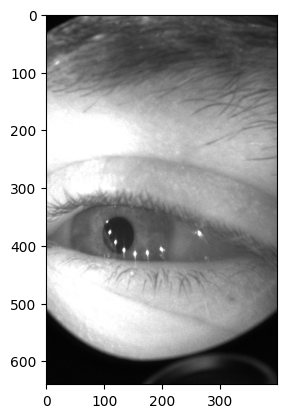

In [2]:
IMAGE_DIR_PATH = 'Semantic_Segmentation_Dataset/train/images/'
image_paths = [os.path.join(IMAGE_DIR_PATH, x) for x in os.listdir(IMAGE_DIR_PATH) if x.endswith('.png')]
image = plt.imread(image_paths[0])
print(image_paths[0])
plt.imshow(image)

Semantic_Segmentation_Dataset/train/labels/000000002610.npy


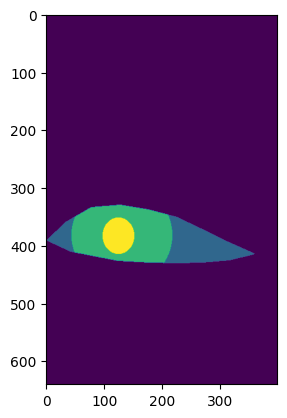

In [3]:
MASK_DIR_PATH ='Semantic_Segmentation_Dataset/train/labels/'
mask_paths = []
mask_paths = [os.path.join(MASK_DIR_PATH, x) for x in os.listdir(MASK_DIR_PATH) if x.endswith('.npy')]
mask = np.load(mask_paths[0])
print(mask_paths[0])
plt.imshow(mask)

In [5]:
def map_func(feature_path):
    # print(feature_path)
    # print(type(feature_path))
    
    # issues with feature_path being read as a numpy array instead of a string, so need to call .numpy() method
    feature = np.load(feature_path.numpy())
    feature = np.expand_dims(feature, axis=-1)
    
    # issues if the datatype is changed uint32, for example, with opencv and resizing
    feature = np.asarray(feature, np.float32)
    feature = tf.convert_to_tensor(feature, np.float32)
    feature.set_shape([640,400,1])
    
    # feature = tf.convert_to_tensor(feature, dtype=tf.uint8)
    # feature = tf.image.convert_image_dtype(feature, dtype=tf.float16)
    # feature = tf.image.encode_png(feature)
    return feature

# def process_masks(file_path)

def process_img(file_path):
    # print(file_path)
    img = tf.io.read_file(file_path)
    img = tf.io.decode_png(img, channels=3)
    # img = tf.cast(img, tf.float32) / 255.0
    # img = tf.reshape(img, [640,400])
    return img

def opencv_resize(img):
    size = (128,128)
    # print(type(img))
    # img = img.numpy()
    res_img = cv2.resize(img, size)
    # print(res_img.shape)

    return res_img

In [6]:
image_ds = tf.data.Dataset.list_files('Semantic_Segmentation_Dataset/train/images/*', shuffle=False)
mask_ds = tf.data.Dataset.list_files('Semantic_Segmentation_Dataset/train/labels/*', shuffle=False)

paths_ds = tf.data.Dataset.zip((image_ds, mask_ds))

In [7]:
for i,j in paths_ds.take(1):
    print(i,j)

tf.Tensor(b'Semantic_Segmentation_Dataset\\train\\images\\000000002610.png', shape=(), dtype=string) tf.Tensor(b'Semantic_Segmentation_Dataset\\train\\labels\\000000002610.npy', shape=(), dtype=string)


In [8]:
IMG_SIZE = 128

def resize_and_rescale(image):
    # image = tf.cast(image, tf.uint8)
    # print(image.shape)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image

In [9]:
# tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

AUTOTUNE = tf.data.AUTOTUNE

# process image_paths into 3-channel image-tensors
# process mask_paths into 1-channel tensors
# when a tf.py_function or tf.numpy_function is called, the tensor loses its shape, need to redefine it
train_ds = paths_ds.map(lambda img, masks: (
                        process_img(img), 
                        tf.py_function(map_func, [masks], tf.float32)
                        # masks
                        ), 
                        num_parallel_calls=AUTOTUNE)

for i,j in train_ds.take(1):
    print(i,j)

tf.Tensor(
[[[ 1  1  1]
  [ 1  1  1]
  [ 4  4  4]
  ...
  [ 6  6  6]
  [ 9  9  9]
  [ 4  4  4]]

 [[ 1  1  1]
  [ 1  1  1]
  [ 6  6  6]
  ...
  [ 9  9  9]
  [ 9  9  9]
  [ 6  6  6]]

 [[ 4  4  4]
  [ 4  4  4]
  [ 4  4  4]
  ...
  [10 10 10]
  [ 9  9  9]
  [10 10 10]]

 ...

 [[ 6  6  6]
  [ 6  6  6]
  [ 4  4  4]
  ...
  [37 37 37]
  [33 33 33]
  [31 31 31]]

 [[ 6  6  6]
  [ 6  6  6]
  [ 4  4  4]
  ...
  [36 36 36]
  [33 33 33]
  [28 28 28]]

 [[ 4  4  4]
  [ 9  9  9]
  [ 4  4  4]
  ...
  [33 33 33]
  [33 33 33]
  [33 33 33]]], shape=(640, 400, 3), dtype=uint8) tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(640, 400, 1), dtype=float32)


C:\Users\Ash\anaconda3\envs\pydml\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [10]:
# IMG_SIZE = 128

# def resize_and_rescale(image):
#   # image = tf.cast(image, tf.uint8)
#   print(image.shape)
#   image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
#   image = (image / 255.0)
#   return image

aug_ds = train_ds.map(
  lambda x, y: (
      resize_and_rescale(x), 
      tf.numpy_function(opencv_resize, [y], tf.float32)
      # y
      ),
      num_parallel_calls=AUTOTUNE)
aug_ds = aug_ds.map(
    lambda x, y: (
        x,
        tf.expand_dims(y, axis=-1)),
      num_parallel_calls=AUTOTUNE
    )
# redefining lost tensor shape
aug_ds = aug_ds.map(
    lambda x, y: (
        x, 
        tf.reshape(y, [IMG_SIZE, IMG_SIZE, 1])),
    num_parallel_calls=AUTOTUNE
)
        

In [164]:
for i,j in aug_ds.take(1):
    print(i,j)

tf.Tensor(
[[[0.01568628 0.01568628 0.01568628]
  [0.01568628 0.01568628 0.01568628]
  [0.02107843 0.02107843 0.02107843]
  ...
  [0.05710785 0.05710785 0.05710785]
  [0.0509804  0.0509804  0.0509804 ]
  [0.03553922 0.03553922 0.03553922]]

 [[0.01568628 0.01568628 0.01568628]
  [0.00612745 0.00612745 0.00612745]
  [0.00759804 0.00759804 0.00759804]
  ...
  [0.09975491 0.09975491 0.09975491]
  [0.0877451  0.0877451  0.0877451 ]
  [0.0752451  0.0752451  0.0752451 ]]

 [[0.00465686 0.00465686 0.00465686]
  [0.02205882 0.02205882 0.02205882]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.10588236 0.10588236 0.10588236]
  [0.09411766 0.09411766 0.09411766]
  [0.0757353  0.0757353  0.0757353 ]]

 ...

 [[0.01617647 0.01617647 0.01617647]
  [0.01715686 0.01715686 0.01715686]
  [0.02916667 0.02916667 0.02916667]
  ...
  [0.15318628 0.15318628 0.15318628]
  [0.11200981 0.11200981 0.11200981]
  [0.10612746 0.10612746 0.10612746]]

 [[0.02303922 0.02303922 0.02303922]
  [0.01715686 0.01715686 0

In [24]:
def augment_try(image_label, seed):
    image, label = image_label
    # image, label = resize_and_rescale(image, label)
    # image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size.
    # image = tf.image.stateless_random_crop(
    #   image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
    # image = tf.clip_by_value(image, 0, 1)
    return image, label

In [26]:
try_aug_ds = (aug_ds
              .map(augment_try, num_parallel_calls=AUTOTUNE)
             )

OperatorNotAllowedInGraphError: in user code:

    File "<ipython-input-24-bf6f7b235ef5>", line 2, in augment_try  *
        image, label = image_label

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


In [8]:
for i,j in aug_ds.take(1):
  # print(i,j)
  print(tf.rank(i), tf.rank(j))
    # print(tf.shape(i), tf.shape(j))
  # plt.imshow(i)
  # plt.figure()
  # plt.imshow(j)

tf.Tensor(3, shape=(), dtype=int32) tf.Tensor(3, shape=(), dtype=int32)


In [31]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        # mode = ""
        # self.augment_inputs = tf.keras.layers.RandomFlip(mode=mode, seed=seed)
        # self.augment_labels = tf.keras.layers.RandomFlip(mode=mode, seed=seed)
        
        factor = 0.2
        self.augment_inputs = tf.keras.layers.RandomBrightness(factor=factor, seed=seed)
        self.augment_labels = tf.keras.layers.RandomBrightness(factor=0, seed=seed)
        
        
        # self.augment_inputs = tf.keras.layers.RandomBrightness(0.1, seed=seed)
        # self.augment_labels = tf.keras.layers.RandomBrightness(0.1, seed=seed)

        # self.augment_inputs = tf.image.stateless_random_brightness()
        # self.augment_labels = tf.image.stateless_random_brightness()
        # self.augment_labels = self.augment_labels

    # def call(self, inputs, labels):
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels
        # return inputs


TRAIN_LENGTH = len(image_ds)
BATCH_SIZE = 1
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = 64


train_batches = (
    aug_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

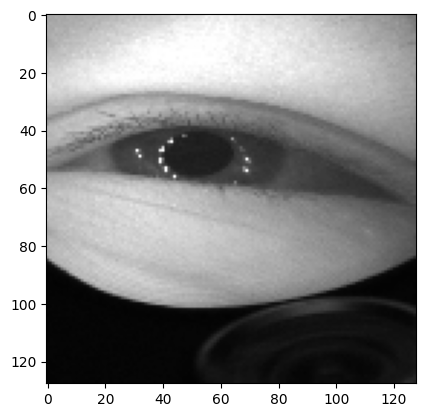

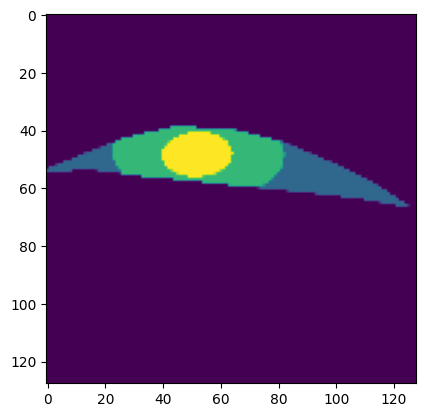

In [33]:
for i,j in train_batches.take(1):
    # print(i[0])
    plt.imshow(i[0])
    plt.figure()
    plt.imshow(j[0])

# Model Training

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_SIZE, IMG_SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [35]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [36]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

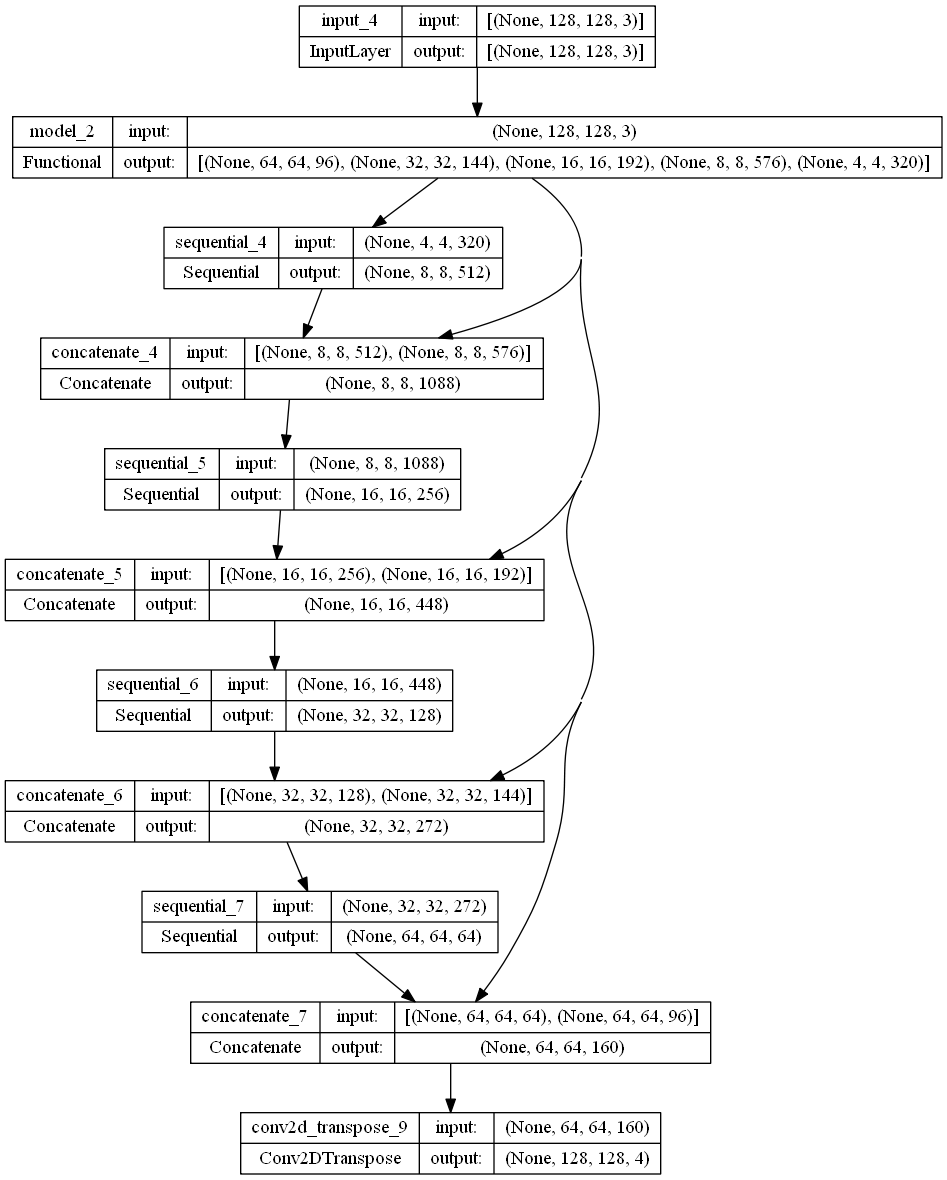

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)

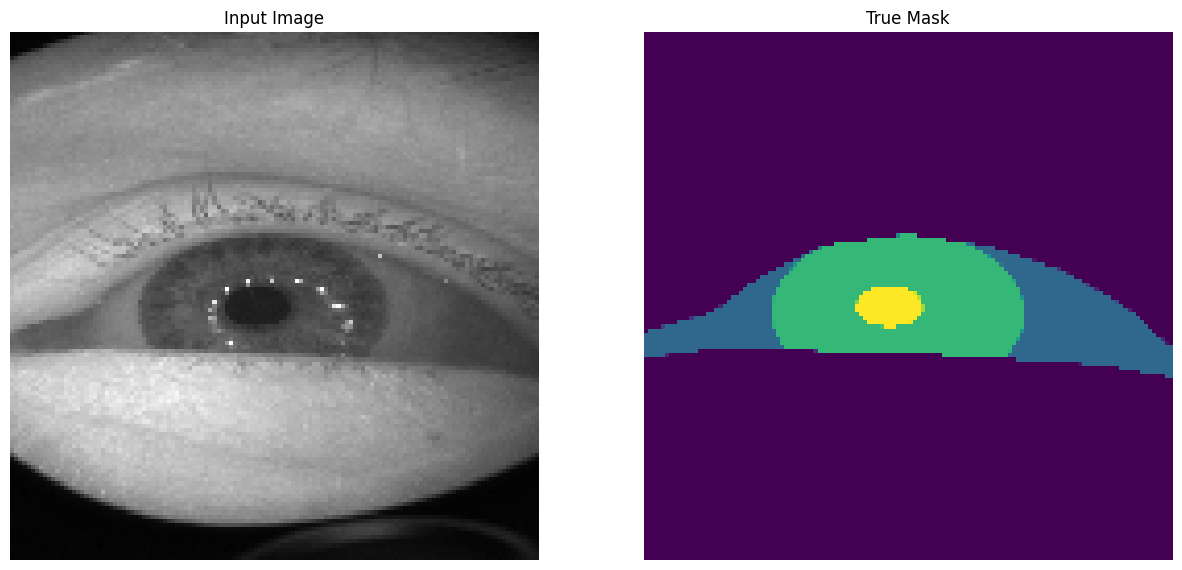

In [38]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    # print(display_list[i].shape)
    if display_list[i].shape[-1] == 1:
      display_list[i] = np.squeeze(display_list[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

1/1 [==============================] - 0s 126ms/step


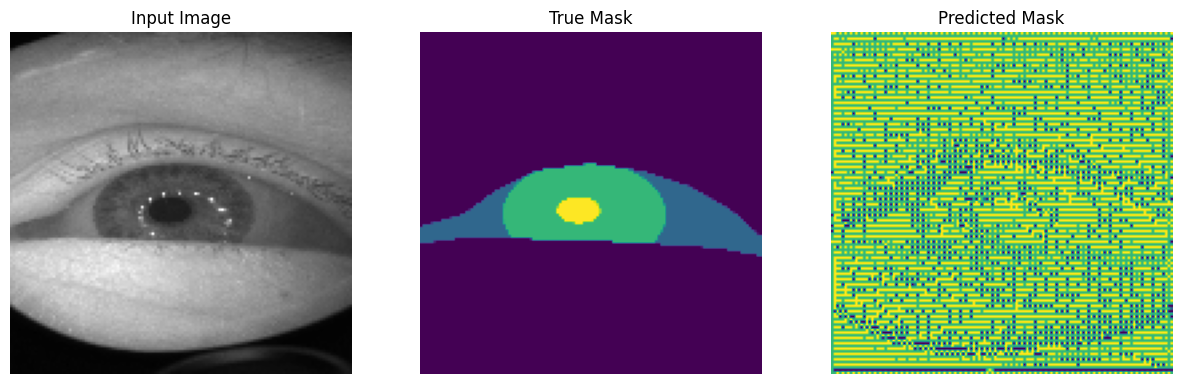

In [39]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  # pred_mask = pred_mask[..., tf.newaxis]
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    # display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [40]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output()
    show_predictions()
    # print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
# BATCH_SIZE = 1
# BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = 64

# train_batches = (
#     train_ds
#     # .cache()
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE)
#     .repeat()
#     # .map(Augment())
#     .prefetch(buffer_size=tf.data.AUTOTUNE))

1/1 [==============================] - 0s 119ms/step


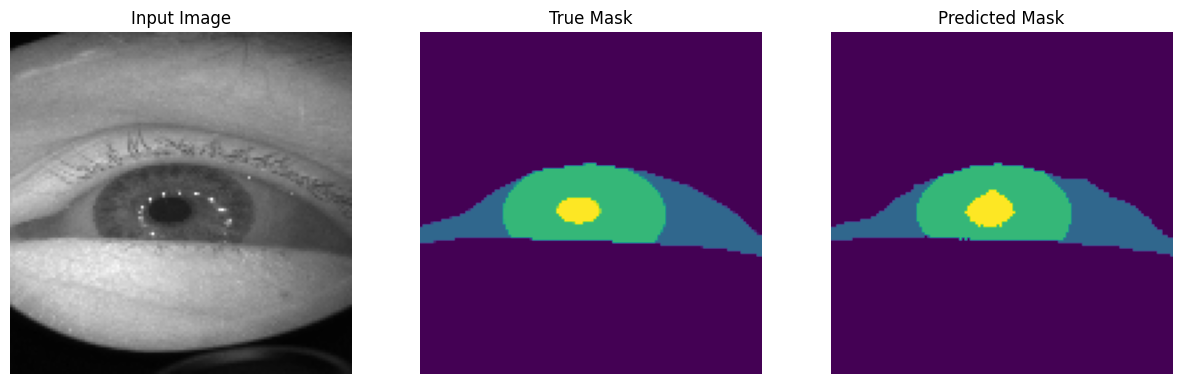

64/64 [==============================] - 15s 233ms/step - loss: 0.0436 - accuracy: 0.9820


In [41]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1 
# //info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          # validation_steps=VALIDATION_STEPS,
                          # validation_data=valid_batches,
                          callbacks=[DisplayCallback()]
                         )

# Inference (only get eyes that are straight ahead)

In [53]:
split_front = ['Semantic_Segmentation_Dataset/infer_split/'+i for i in os.listdir('Semantic_Segmentation_Dataset/infer_split/') if int(i.split('.')[0])%2==1]

In [56]:
def import_split_eyes(path):
    size = (IMG_SIZE, IMG_SIZE)
    image_ds = tf.data.Dataset.from_tensor_slices(path)
    image_ds = image_ds.map(lambda x: process_img(x))
    image_ds = image_ds.map(lambda x: (tf.image.resize(x, size)))
    
    return image_ds

infer_ds_try = import_split_eyes(split_front)

C:\Users\Ash\anaconda3\envs\pydml\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


dataset read
1/1 [==============================] - 0s 145ms/step


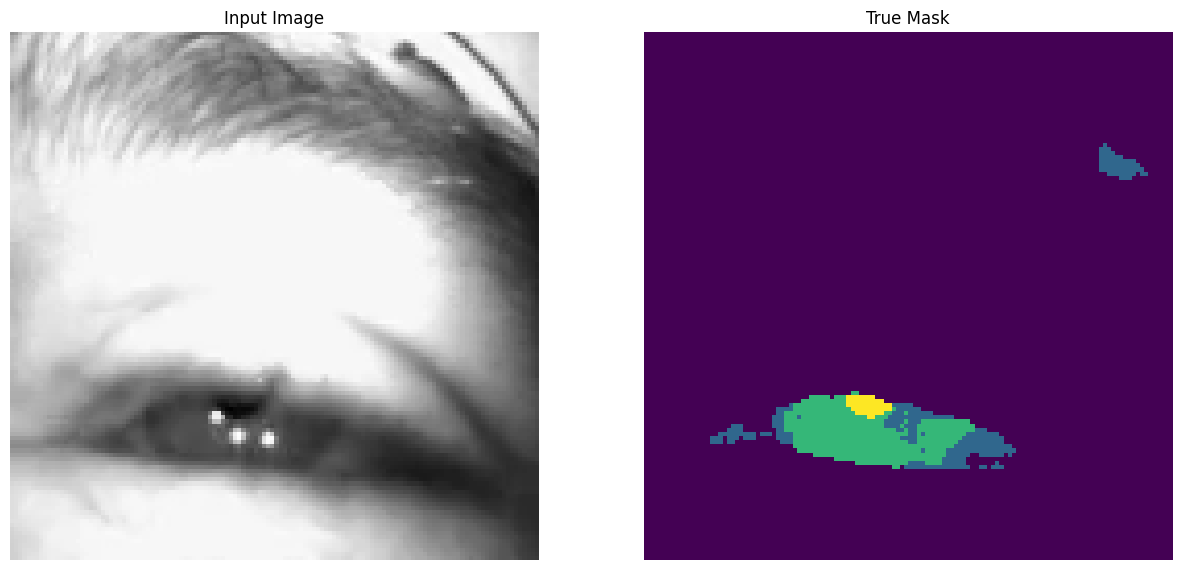

1/1 [==============================] - 0s 146ms/step


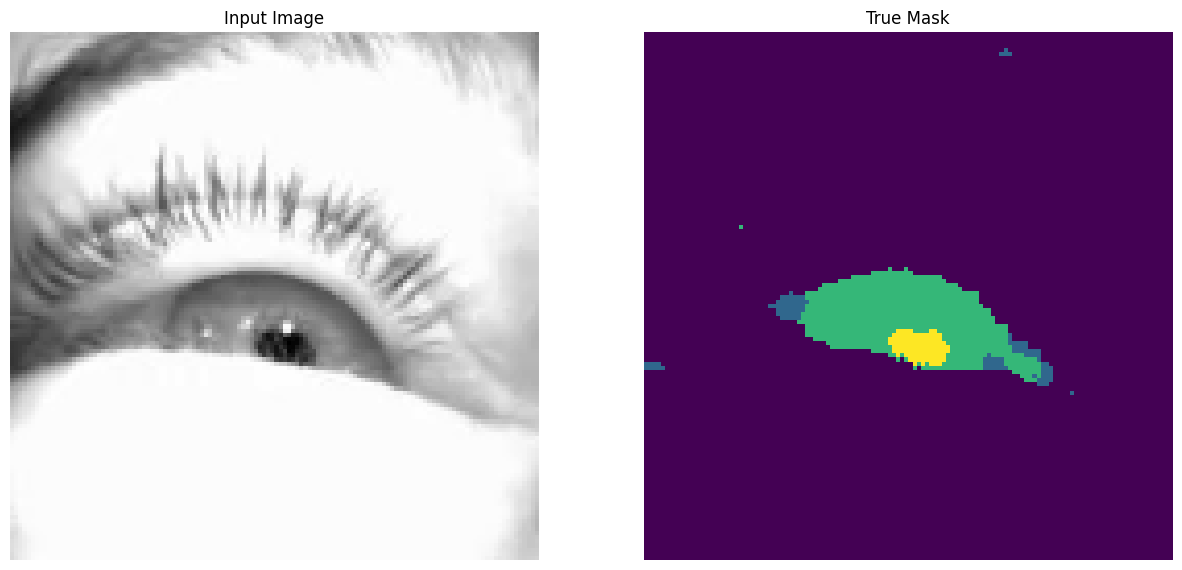

1/1 [==============================] - 0s 117ms/step


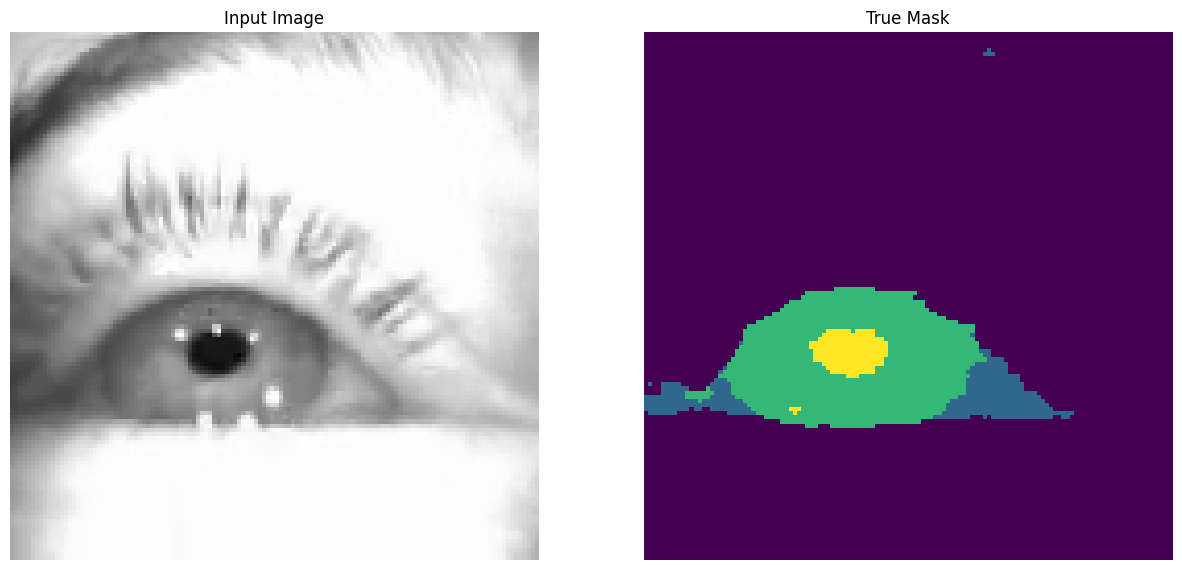

1/1 [==============================] - 0s 123ms/step


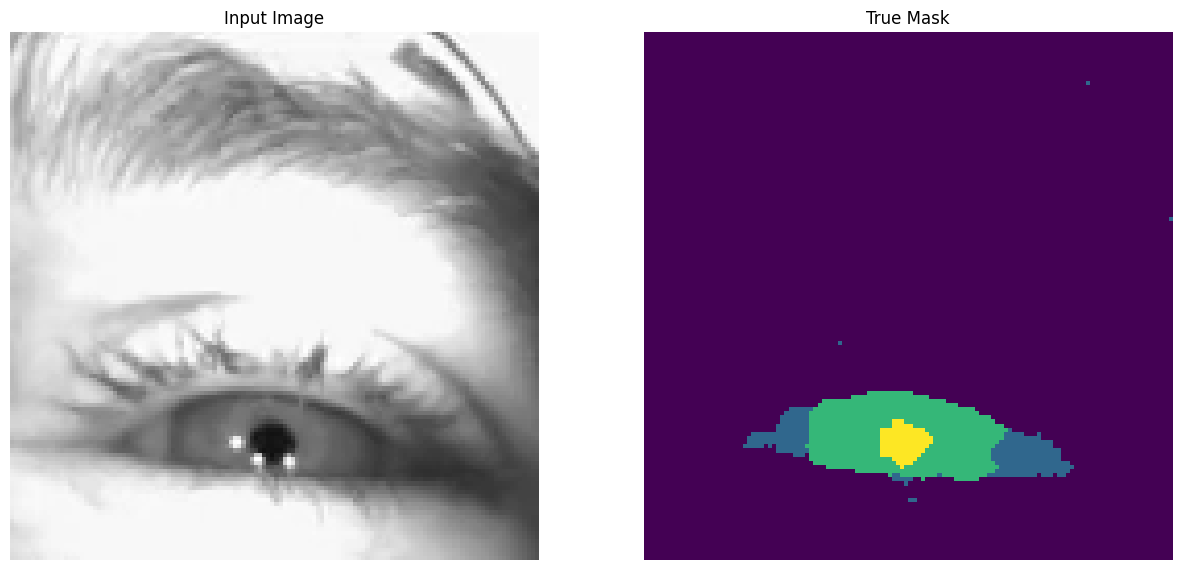

1/1 [==============================] - 0s 119ms/step


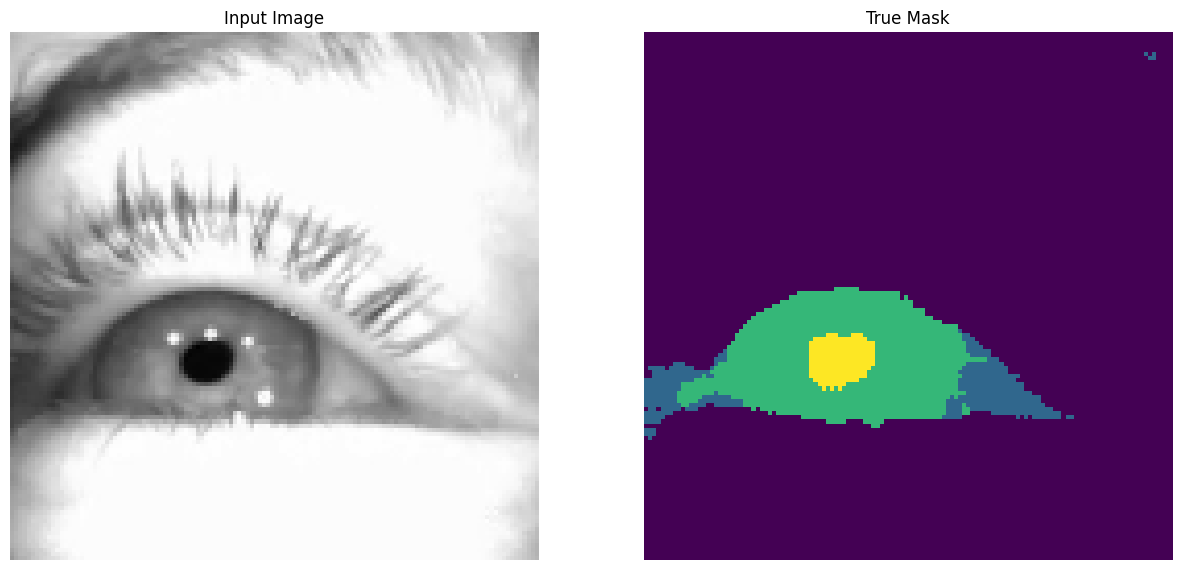

1/1 [==============================] - 0s 132ms/step


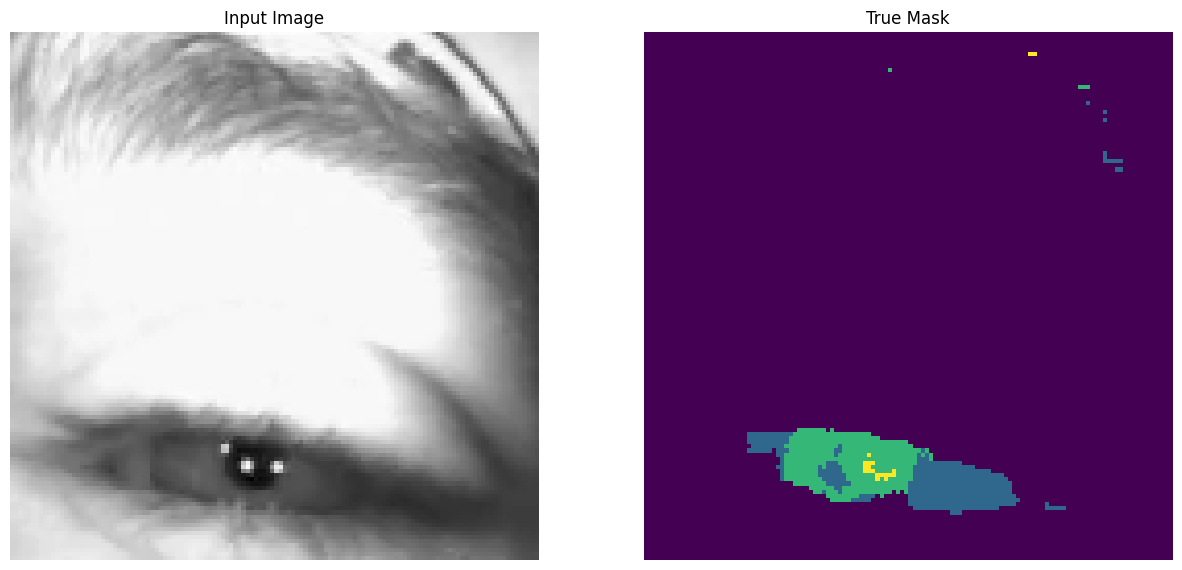

1/1 [==============================] - 0s 122ms/step


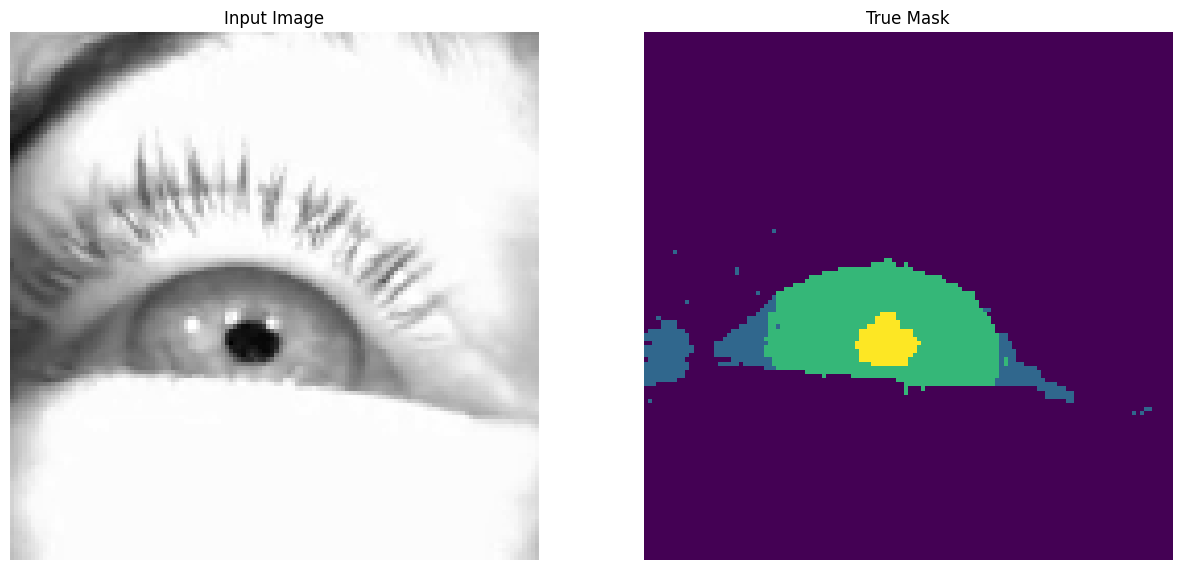

1/1 [==============================] - 0s 112ms/step


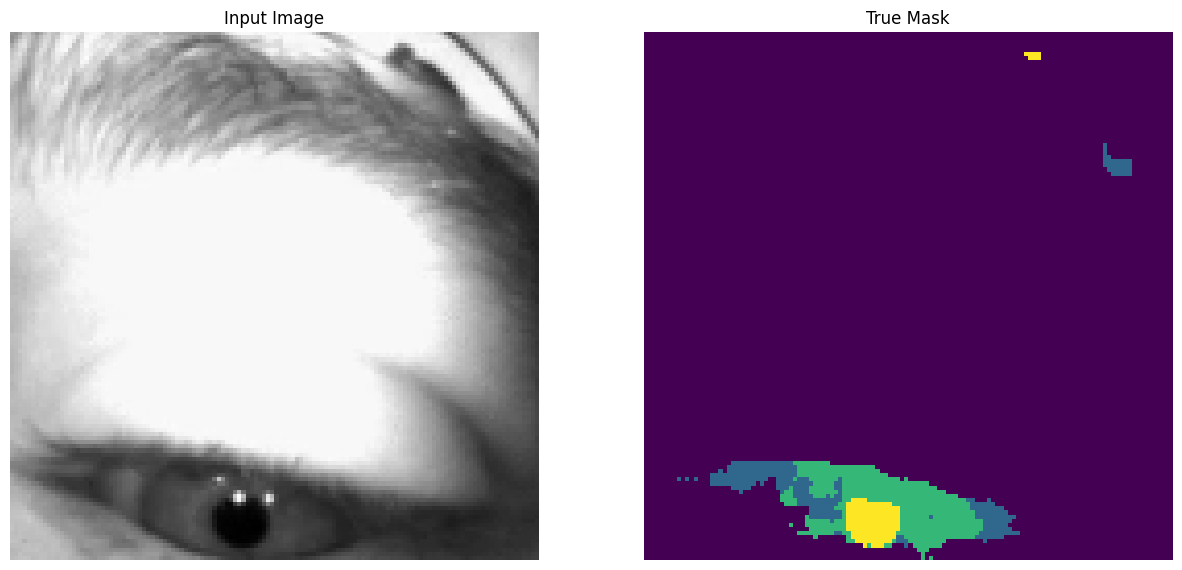

1/1 [==============================] - 0s 123ms/step


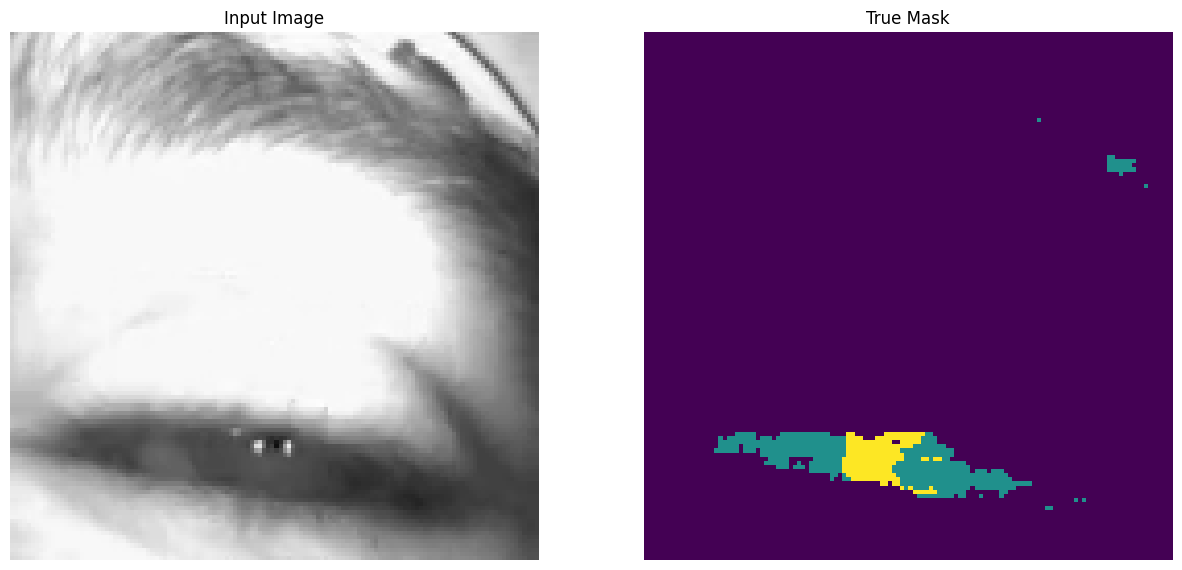

1/1 [==============================] - 0s 116ms/step


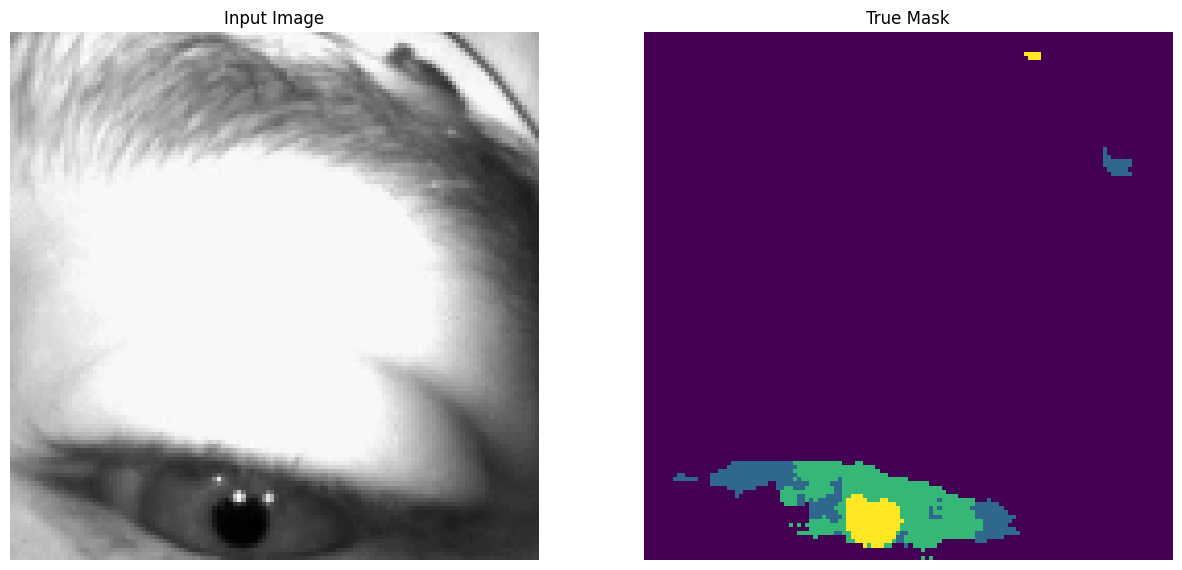

In [58]:

def import_images(path):
    size = (IMG_SIZE, IMG_SIZE)
    image_ds = tf.data.Dataset.list_files(path, shuffle=False)
    image_ds = image_ds.map(lambda x: process_img(x))
    image_ds = image_ds.map(lambda x: (tf.image.resize(x, size)))
    
    return image_ds

def create_infer_data(train_ds):
    
    # train_ds = tf.data.Dataset.zip((image_ds, mask_ds))
    train_ds = train_ds.map(lambda x : (tf.cast(x, 'uint8')/255))
    
    return train_ds

def show_infer_predictions(dataset=None, num=1):
  if dataset:
    print('dataset read')
    for image in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], create_mask(pred_mask)])
  else:
    print('dataset not read')
    # display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
def create_infer_batch(train_ds):
    BATCH_SIZE = 1
    BUFFER_SIZE = 1000
    STEPS_PER_EPOCH = 64

    train_batches = (
        train_ds
        # .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        # .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))
    
    return train_batches
    

# infer_images = import_images('Semantic_Segmentation_Dataset/infer_split/*')
infer_images = import_split_eyes(split_front)
infer_data = create_infer_data(infer_images)
infer_batch = create_infer_batch(infer_data)

show_infer_predictions(dataset=infer_batch, num=10)

In [59]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

# Augmenting ONE image

In [92]:
openCVImage = np.load(mask_paths[0])
openCVImage = np.expand_dims(openCVImage, axis=-1)
openCVImageAsArray = np.asarray(openCVImage, np.float32)
image = tf.convert_to_tensor(openCVImageAsArray, np.float32)

In [93]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


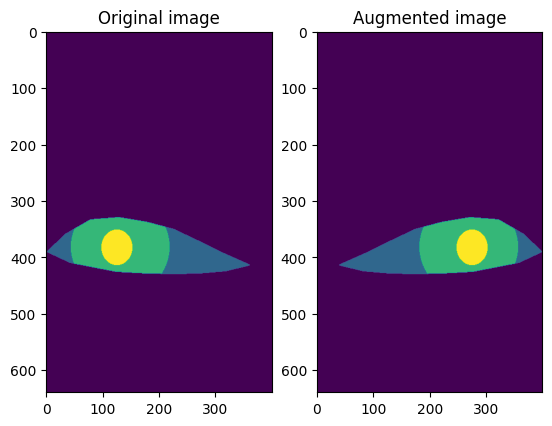

In [94]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)